# Welcome to Seeq Data Lab!
Seeq Data Lab is a rich Python-based environment for exploring and manipulating time series and industrial process data. It is built on the [Jupyter](https://jupyter.org/) interactive Python platform and [Pandas](https://pandas.pydata.org/) data structures, making extensive use of the features and conventions that their user communities have established.

Any datasources that are connected to your Seeq Server are easy to access via Seeq Data Lab's `spy` library. Several simple function calls like `search`, `pull` and `push` consume and/or produce [DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) whenever possible so that you can use their powerful data manipulation capabilities and concise syntax.

This tutorial walks you through the basics of searching for data, getting it into a DataFrame and then writing it back to a Seeq Workbench workbook.

# Getting Started
This section will walk you through searching for signals in Seeq and pulling data.

## Importing the SPy Module
The **SPy** module (short for Seeq PYthon) is what you'll use to interact with Seeq Server and access data. Start by importing it.

In [1]:
from seeq import spy

You'll also want to import Pandas so that you can work with the DataFrame structures that the **spy** library consumes/produces.

In [2]:
import pandas as pd

## Logging in to Seeq

**If you are using Seeq Data Lab, then this step is NOT necessary.** If you are using the SPy module with Anaconda, AWS SageMaker, Azure Notebooks or any other Jupyter Notebook solution, you will need to execute this step.

Create a file in the root folder of your Jupyter project called `credentials.key` and put your username on the first line and your password on the second.

If you log in to Seeq Server using your corporate credentials (aka "Single Sign-On"), please take a look at the [spy.login](spy.login.ipynb) documentation for information about logging in with an Access Key.

In [3]:
spy.login(url='http://localhost:34216', credentials_file='../credentials.key', force=False)

## Searching for Signals
Now let's find some data. We're going to use the built-in Seeq example data to retrieve a few signals and look at them as DataFrames.

First we'll use the `spy.search()` function to retrieve metadata.

In [4]:
results = spy.search({
    "Path": "Example >> Cooling Tower 1 >> Area A"
})

# Print the output to the Jupyter page
results

,Path,Time,Count,Pages,Result
0,Example >> Cooling Tower 1 >> Area A,00:00:00.07,6,1,Success


,ID,Path,Asset,Name,Description,Type,Value Unit Of Measure,Datasource Name,Archived
0,0630E626-1DD0-48CF-B58C-C13620C0787E,Example >> Cooling Tower 1,Area A,Optimizer,NaN,StoredSignal,NaN,Example Data,False
1,6CC32A60-5124-46F8-8C6A-6357C2A8FD5B,Example >> Cooling Tower 1,Area A,Wet Bulb,NaN,StoredSignal,°F,Example Data,False
2,837ACED9-5A62-41CC-AE4D-3C102AB40E7C,Example >> Cooling Tower 1,Area A,Compressor Power,NaN,StoredSignal,kW,Example Data,False
3,858553AA-E937-4F8C-820C-1C37DB5DE2D1,Example >> Cooling Tower 1,Area A,Relative Humidity,NaN,StoredSignal,%,Example Data,False
4,DC073F96-C69A-491A-B54F-FBBD8874FA5E,Example >> Cooling Tower 1,Area A,Temperature,NaN,StoredSignal,°F,Example Data,False
5,E319BB0C-1A2E-43AC-B9BD-98A0783CB425,Example >> Cooling Tower 1,Area A,Compressor Stage,NaN,StoredSignal,string,Example Data,False


## Refining the Results

Let's pare down the results to just three signals before we pull some data.

In [5]:
my_signals = results.loc[results['Name'].isin(['Compressor Power', 'Temperature', 'Relative Humidity'])]
my_signals

,ID,Path,Asset,Name,Description,Type,Value Unit Of Measure,Datasource Name,Archived
2,837ACED9-5A62-41CC-AE4D-3C102AB40E7C,Example >> Cooling Tower 1,Area A,Compressor Power,NaN,StoredSignal,kW,Example Data,False
3,858553AA-E937-4F8C-820C-1C37DB5DE2D1,Example >> Cooling Tower 1,Area A,Relative Humidity,NaN,StoredSignal,%,Example Data,False
4,DC073F96-C69A-491A-B54F-FBBD8874FA5E,Example >> Cooling Tower 1,Area A,Temperature,NaN,StoredSignal,°F,Example Data,False


Now let's pull in the data using Seeq. The data can come from any connected datasource, including historians like *OSIsoft PI*, time series stores like *InfluxDB*, and SQL databases like *Microsoft SQL Server*.

You can specify the `grid` parameter to control the granularity of the data. Seeq's calculation engine will interpolate as needed to produce a uniform DataFrame. Specify `grid=None` if you want the raw data.

In [6]:
my_data = spy.pull(my_signals, start='2019-01-01', end='2019-01-07', grid='30min', header='Name')
my_data.head()

,ID,Path,Asset,Name,Time,Count,Pages,Result
2,837ACED9-5A62-41CC-AE4D-3C102AB40E7C,Example >> Cooling Tower 1,Area A,Compressor Power,00:00:00.01,289,1,Success
3,858553AA-E937-4F8C-820C-1C37DB5DE2D1,Example >> Cooling Tower 1,Area A,Relative Humidity,00:00:00.02,289,1,Success
4,DC073F96-C69A-491A-B54F-FBBD8874FA5E,Example >> Cooling Tower 1,Area A,Temperature,00:00:00.01,289,1,Success


,Compressor Power,Relative Humidity,Temperature
2019-01-01 00:00:00+00:00,39.189300,42.729850,93.861500
2019-01-01 00:30:00+00:00,39.949065,39.848041,95.056341
2019-01-01 01:00:00+00:00,39.326496,38.005187,97.057959
2019-01-01 01:30:00+00:00,39.977703,36.986019,97.894497
2019-01-01 02:00:00+00:00,40.223175,36.274775,97.858900


## Plotting the Results
Let's take a quick peek at the data we just pulled using the built in `DataFrame.plot()` function.

<AxesSubplot:>

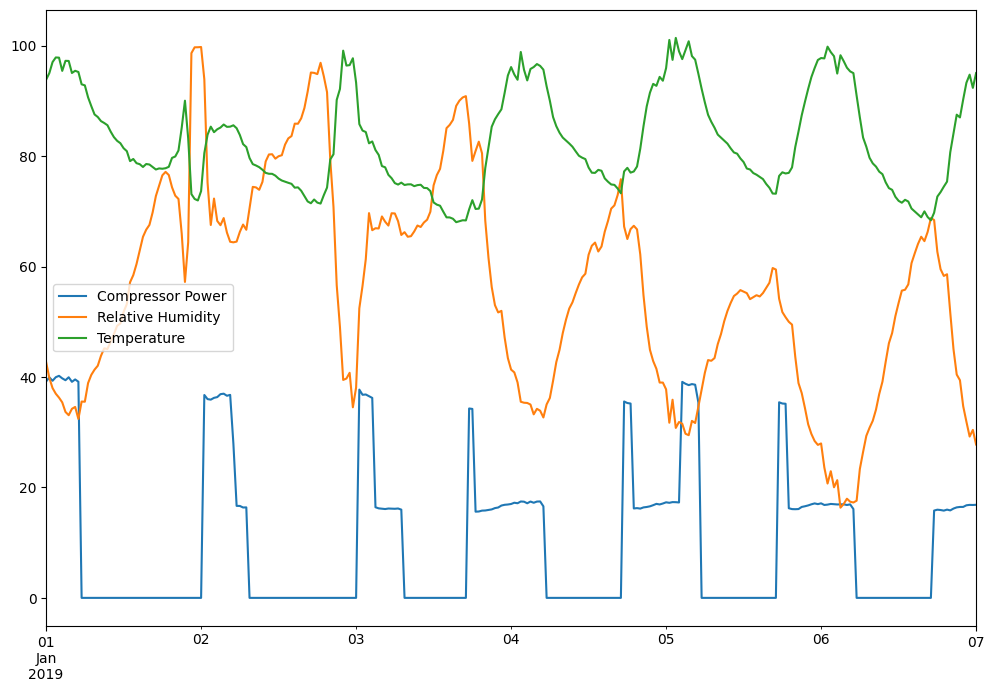

In [7]:
import matplotlib
import matplotlib.pyplot as plt

# Make the plot render at a bigger size than default
matplotlib.rcParams['figure.figsize'] = [12, 8]

my_data.plot()

**NOTE: Sometimes you have to execute the cell above twice for the plot to show. Not sure why.**

How about a matrix of scatterplots, with each variable plotted against each other? Pandas can do that easily.

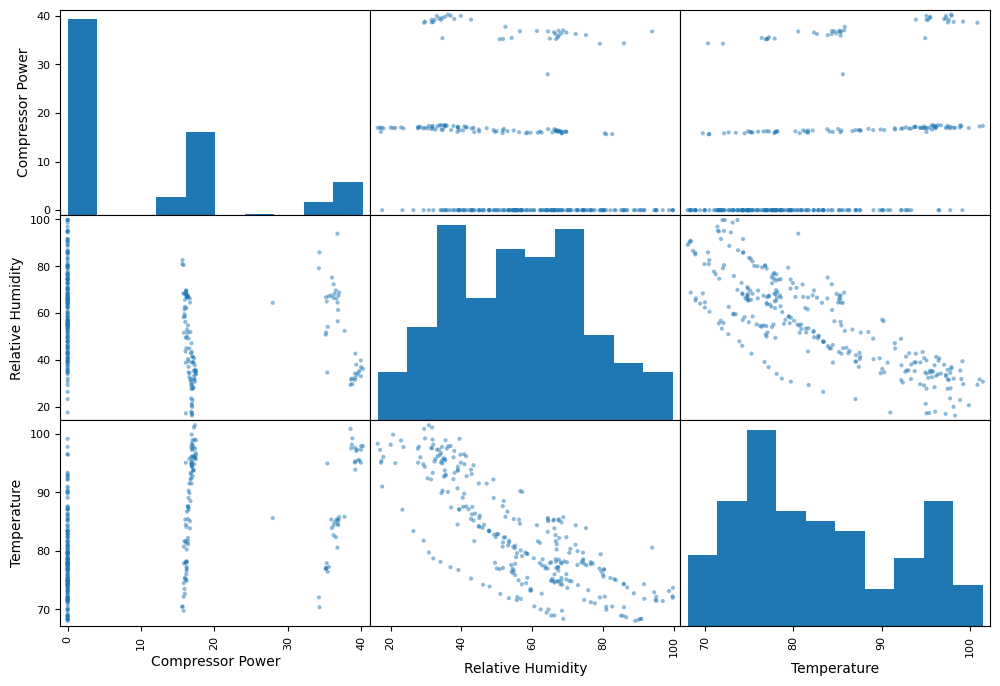

In [8]:
pd.plotting.scatter_matrix(my_data)
plt.show()

# Using Seeq's Calculation Engine

What if we want to use Seeq's calculation engine to reduce the noise in the **Temperature** and **Relative Humidity** signals?

We can apply a calculation by specifying a formula as the `calculation` argument.

In [9]:
calculated_data = spy.pull(
    my_signals,
    start='2019-01-01',
    end='2019-01-07',
    calculation='$signal.lowPassFilter(200min, 3min, 333)',
    grid='5min',
    header='Name')
calculated_data.head()

,ID,Path,Asset,Name,Time,Count,Pages,Result
2,837ACED9-5A62-41CC-AE4D-3C102AB40E7C,Example >> Cooling Tower 1,Area A,Compressor Power,00:00:00.04,1729,1,Success
3,858553AA-E937-4F8C-820C-1C37DB5DE2D1,Example >> Cooling Tower 1,Area A,Relative Humidity,00:00:00.03,1729,1,Success
4,DC073F96-C69A-491A-B54F-FBBD8874FA5E,Example >> Cooling Tower 1,Area A,Temperature,00:00:00.05,1729,1,Success


,Compressor Power,Relative Humidity,Temperature
2019-01-01 00:00:00+00:00,39.521423,41.582681,95.011676
2019-01-01 00:05:00+00:00,39.560133,41.257888,95.175356
2019-01-01 00:10:00+00:00,39.591796,40.943507,95.333398
2019-01-01 00:15:00+00:00,39.615497,40.639047,95.485623
2019-01-01 00:20:00+00:00,39.629214,40.345067,95.631086


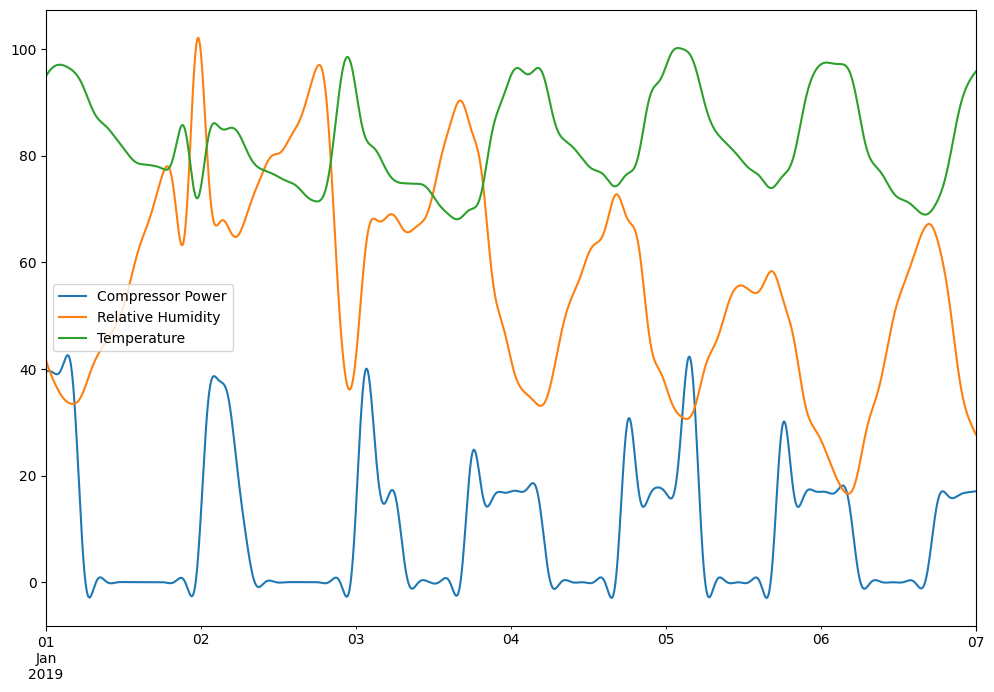

In [10]:
calculated_data.plot()

plt.show()

## Pushing a New Condition to Seeq

Let's push a Seeq *Condition* into our workbook.

In [11]:
push_results = spy.push(metadata=pd.DataFrame([{
    'Name': 'Compressor on High',
    'Type': 'Condition',
    'Formula': '$cp.valueSearch(isGreaterThan(25kW))',
    'Formula Parameters': {
        # Note here that we are just using a row from our search results. The SPy module will figure
        # out that it contains an identifier that we can use.
        '$cp': results[results['Name'] == 'Compressor Power']
    }
}]), workbook='SPy Documentation Examples >> Tutorial')

push_results

,Name,Type,Formula,Formula Parameters,Datasource Class,Datasource ID,Data ID,ID,Push Result
0,Compressor on High,CalculatedCondition,$cp.valueSearch(isGreaterThan(25kW)),[cp=837ACED9-5A62-41CC-AE4D-3C102AB40E7C],Seeq Data Lab,Seeq Data Lab,[2C4F44C6-DE87-407B-9A45-4CDE3E188409] {Condit...,FCAC5C3D-F859-4167-B86E-AB89D712A8BA,Success


## Pulling the Capsules

In [12]:
capsules = spy.pull(push_results, start='2019-01-01', end='2019-01-07')
capsules

,ID,Name,Time,Count,Pages,Result
0,FCAC5C3D-F859-4167-B86E-AB89D712A8BA,Compressor on High,00:00:00.01,7,1,Success


,Condition,Capsule Start,Capsule End,Capsule Is Uncertain
0,Compressor on High,NaT,2019-01-01 05:01:31.176600146+00:00,False
1,Compressor on High,2019-01-02 00:16:37.331031739+00:00,2019-01-02 05:00:33.238973103+00:00,False
2,Compressor on High,2019-01-03 00:13:18.731947840+00:00,2019-01-03 02:55:03.027869976+00:00,False
3,Compressor on High,2019-01-03 17:28:04.251451273+00:00,2019-01-03 18:21:58.603314005+00:00,False
4,Compressor on High,2019-01-04 17:20:33.782090068+00:00,2019-01-04 18:46:41.571969511+00:00,False
5,Compressor on High,2019-01-05 02:18:11.253715409+00:00,2019-01-05 05:01:23.108876186+00:00,False
6,Compressor on High,2019-01-05 17:20:29.256597642+00:00,2019-01-05 18:43:39.192264349+00:00,False


## Plotting Conditions Alongside Signals
Now let's use the new condition in a plot, this time using `spy.plot()`, which has a set of predefined plot configurations.

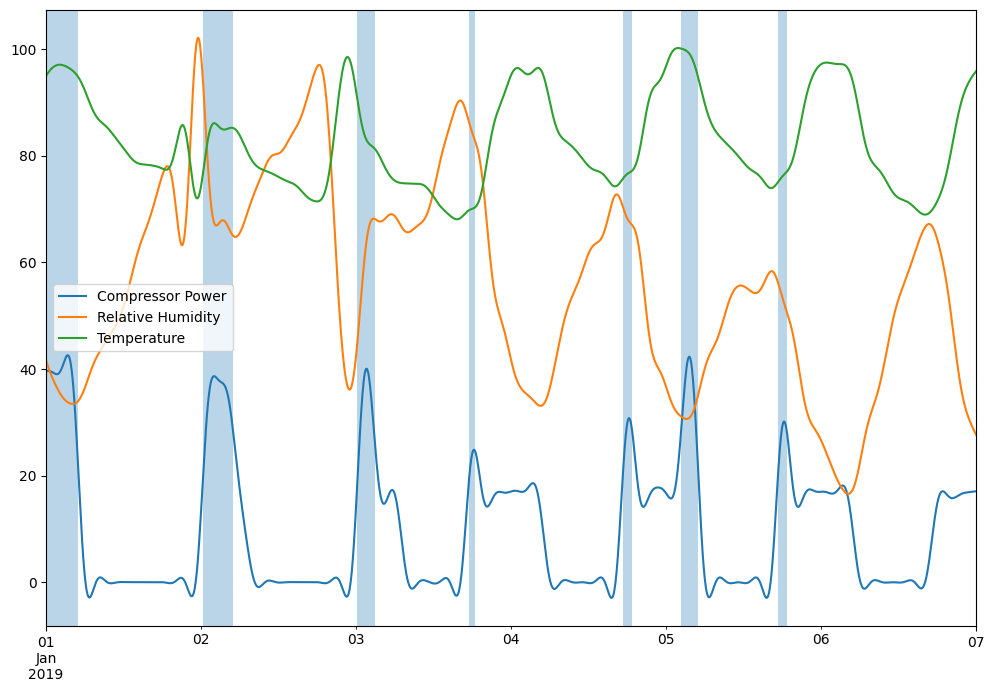

In [13]:
samples = calculated_data

spy.plot(samples=samples, capsules=capsules)

## Calculating a New Signal using Python
One reason you wanted to get the data into Python in the first place is to create new data. Let's clip **Compressor Power** by 10 so it simplifies to just representing power on or off.

In [14]:
def attenuate_power(sample):
    return min(sample, 10)


clipped_data = pd.DataFrame({'Compressor Power': my_data['Compressor Power'],
                             'Attenuated Power': my_data['Compressor Power'].apply(attenuate_power)})
clipped_data.head()

,Compressor Power,Attenuated Power
2019-01-01 00:00:00+00:00,39.189300,10.0
2019-01-01 00:30:00+00:00,39.949065,10.0
2019-01-01 01:00:00+00:00,39.326496,10.0
2019-01-01 01:30:00+00:00,39.977703,10.0
2019-01-01 02:00:00+00:00,40.223175,10.0


<AxesSubplot:>

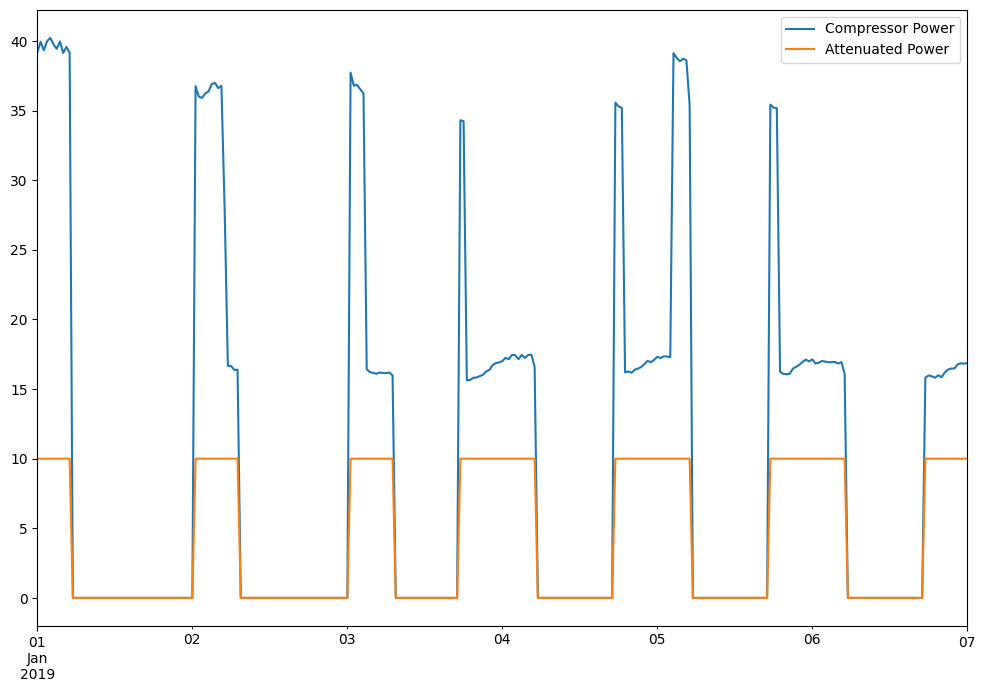

In [15]:
clipped_data.plot()

## Pushing Data Into Seeq
Jupyter is a great environment for programming, but let's go back to Seeq Workbench and make things truly interactive.

In [16]:
spy.push(clipped_data, workbook='SPy Documentation Examples >> Tutorial')

,Count,Pages,Result,Time
Compressor Power,289,1,Success,00:00:00.08
Attenuated Power,289,1,Success,00:00:00.09


,Push Count,Push Time,Push Result,Name,ID,Type
Compressor Power,289.0,0:00:00.082000,Success,Compressor Power,CC42925D-2756-460C-9892-E1A687A92AB9,StoredSignal
Attenuated Power,289.0,0:00:00.086997,Success,Attenuated Power,79C4BB38-DBF2-4B49-BAF3-F7387CBFAA03,StoredSignal


The data is now in Seeq's internal time series database and is scoped to a workbook. Click the link above to see it!